Total bursts detectados: 277


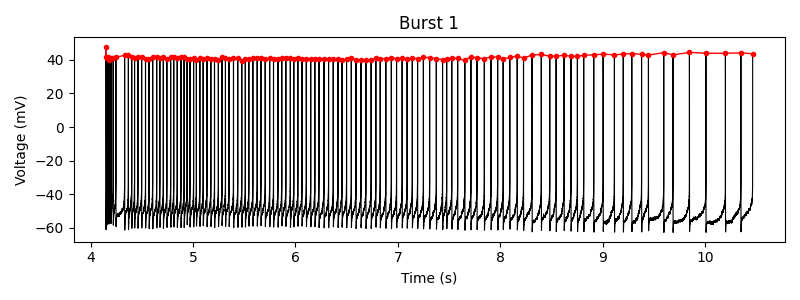

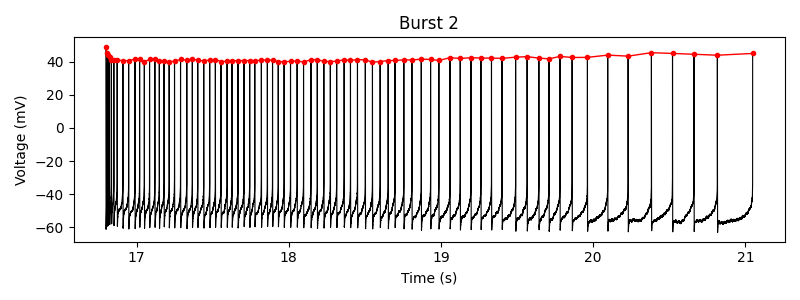

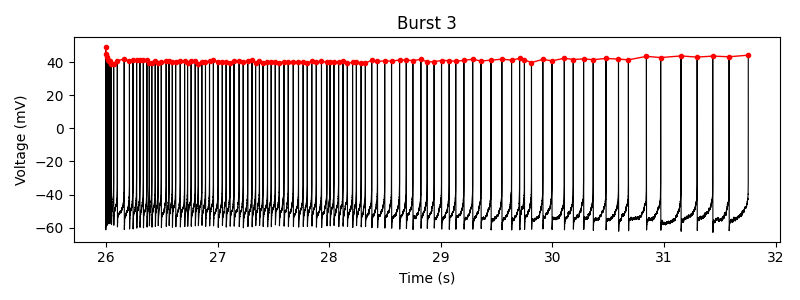

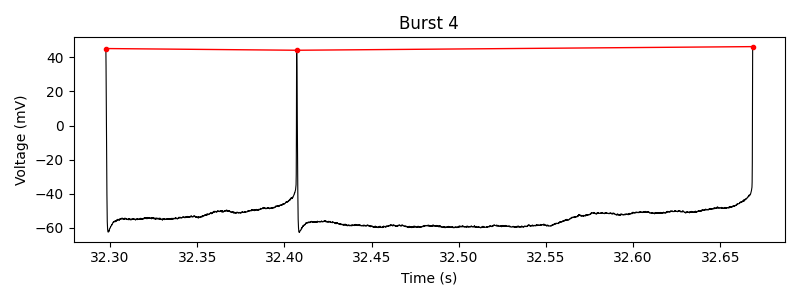

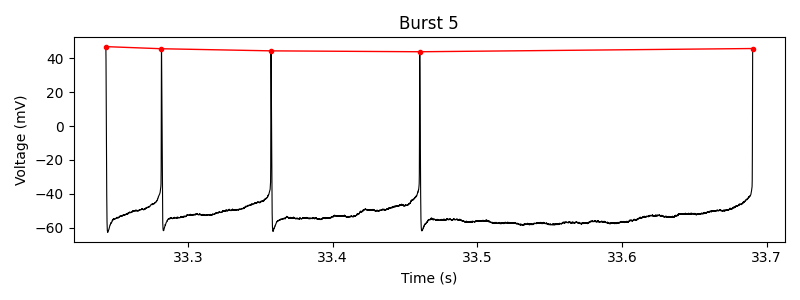

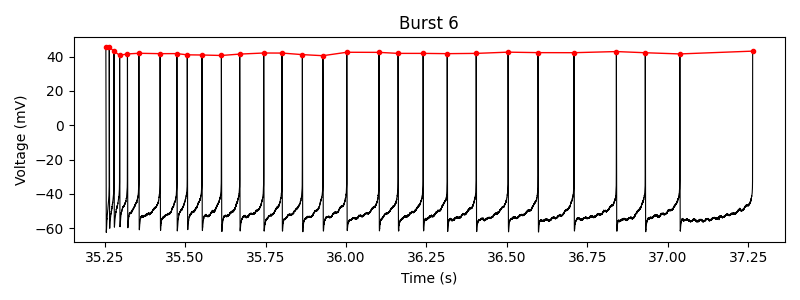

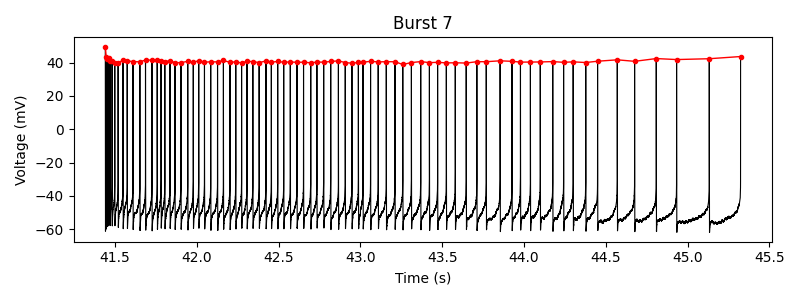

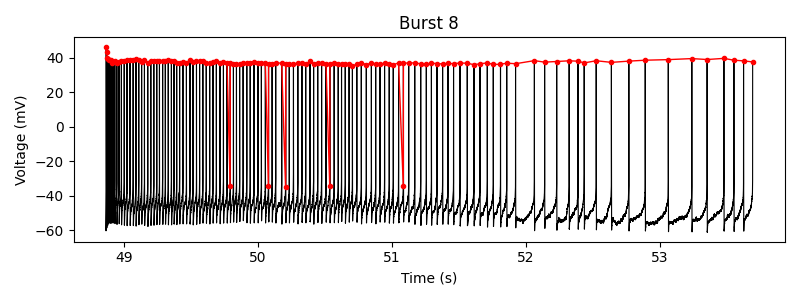

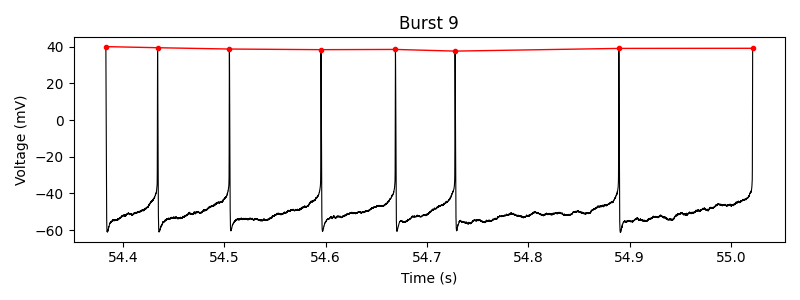

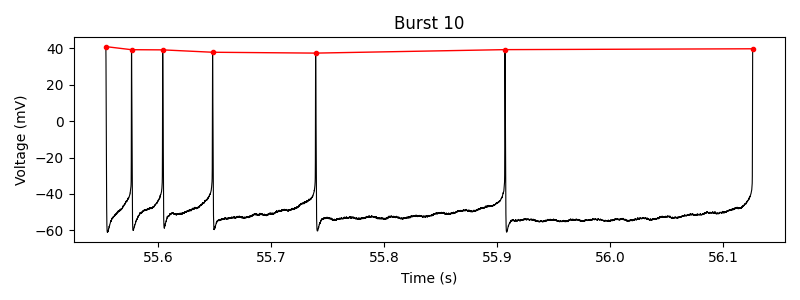

In [7]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
%matplotlib widget
# ==== Cargar datos ====
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)

# Concatenar sweeps
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])
dt = 1.0 / abf.dataRate
time = np.arange(len(signal)) * dt

# ==== Detección de spikes ====
threshold = -35  # mV
spike_indices, _ = find_peaks(signal, height=threshold)
spike_times = time[spike_indices]

# ==== Detección de bursts ====
isi = np.diff(spike_times)
burst_threshold = 0.3  # s

bursts = []
current_burst = [spike_times[0]]
for i in range(1, len(isi)):
    if isi[i-1] < burst_threshold:
        current_burst.append(spike_times[i])
    else:
        if len(current_burst) > 1:
            bursts.append(current_burst)
        current_burst = [spike_times[i]]
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Total bursts detectados: {len(bursts)}")

# ==== Representar los primeros 10 bursts (uno por figura) ====
n_bursts_to_plot = min(10, len(bursts))

for i in range(n_bursts_to_plot):
    burst = bursts[i]

    # Máscara para recortar la señal en la ventana del burst
    mask = (time >= burst[0]) & (time <= burst[-1])
    t_burst = time[mask]
    s_burst = signal[mask]

    # Picos del burst (usar spike_indices dentro del intervalo)
    burst_peak_mask = (spike_times >= burst[0]) & (spike_times <= burst[-1])
    burst_spike_times = spike_times[burst_peak_mask]
    burst_spike_values = signal[spike_indices][burst_peak_mask]

    # Crear figura para cada burst
    plt.figure(figsize=(8, 3))
    plt.plot(t_burst, s_burst, lw=0.8, color="black")
    plt.plot(burst_spike_times, burst_spike_values, "ro", markersize=3)
    plt.plot(burst_spike_times, burst_spike_values, "r-", lw=1)

    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.title(f"Burst {i+1}")
    plt.tight_layout()
    plt.show()

Total detected bursts: 277


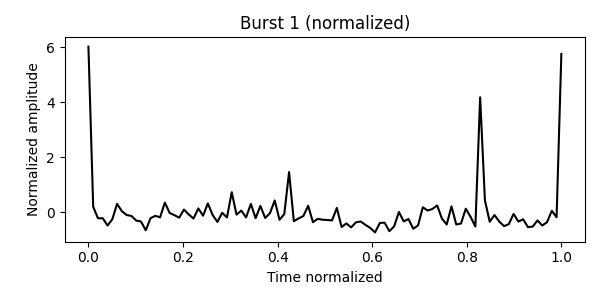

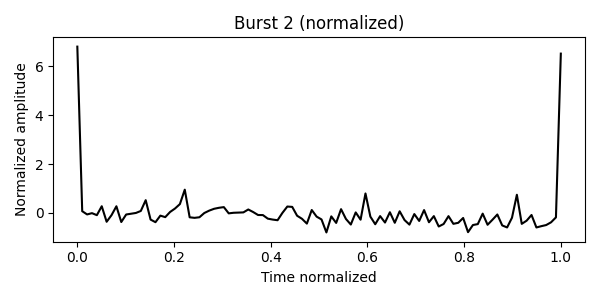

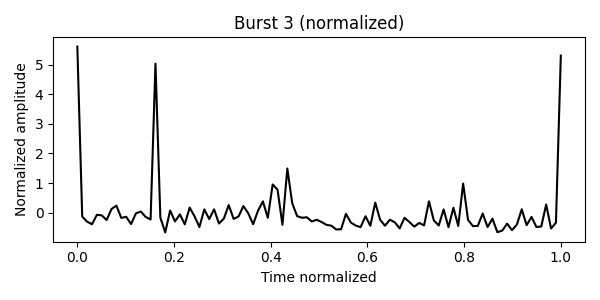

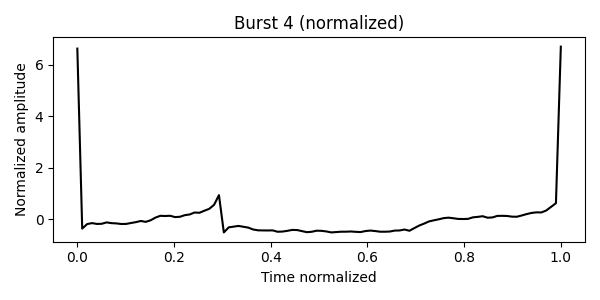

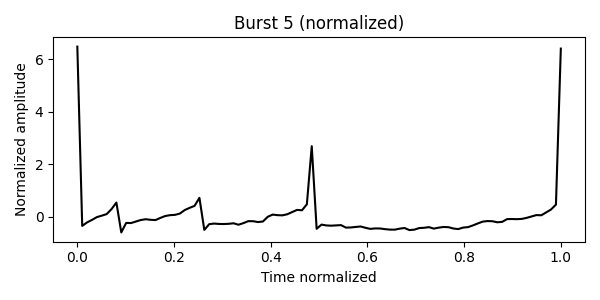

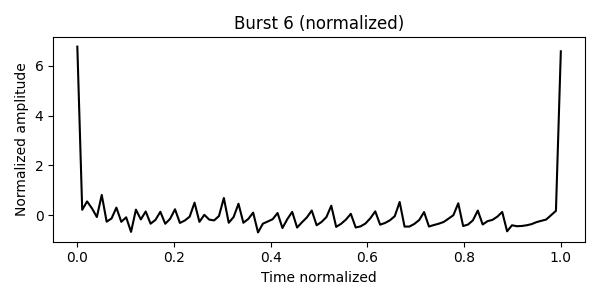

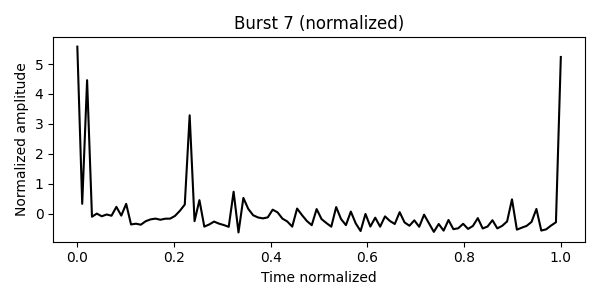

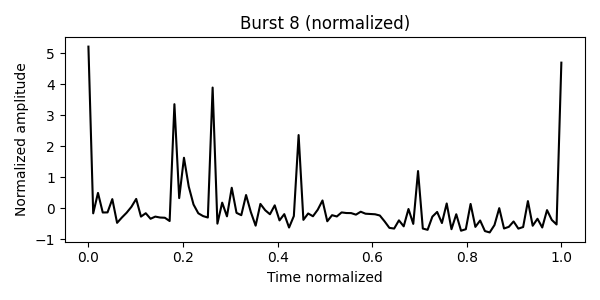

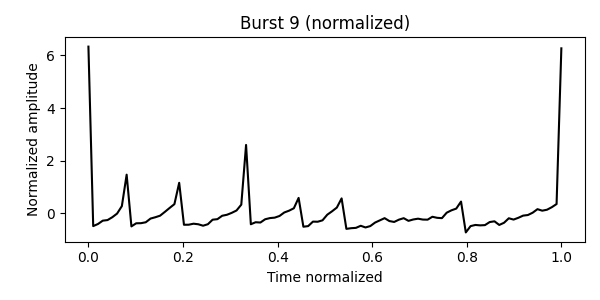

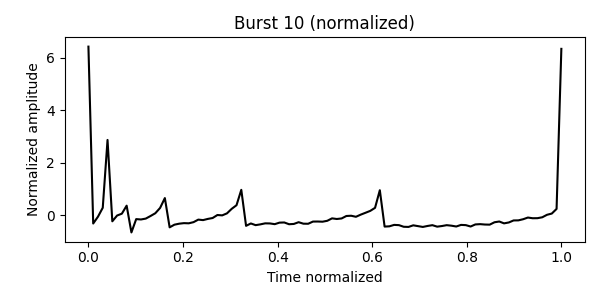

In [8]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# ==== Cargar datos ====
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)

# Concatenar sweeps
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])
dt = 1.0 / abf.dataRate
time = np.arange(len(signal)) * dt

# ==== Detección de spikes ====
threshold = -35  # mV
spike_indices, _ = find_peaks(signal, height=threshold)
spike_times = time[spike_indices]

# ==== Detección de bursts ====
isi = np.diff(spike_times)
burst_threshold = 0.3  # s

bursts = []
current_burst = [spike_times[0]]
for i in range(1, len(isi)):
    if isi[i-1] < burst_threshold:
        current_burst.append(spike_times[i])
    else:
        if len(current_burst) > 1:
            bursts.append(current_burst)
        current_burst = [spike_times[i]]
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Total detected bursts: {len(bursts)}")

# ==== Funciones de normalización ====
def normalize_y(signal_segment):
    """Normaliza amplitud con z-score"""
    return (signal_segment - np.mean(signal_segment)) / np.std(signal_segment)

def rescale_x(time_segment, signal_segment, n_points=100):
    """Reescala en duración (interpola a n_points)"""
    f = interp1d(np.linspace(0, 1, len(signal_segment)), signal_segment)
    return f(np.linspace(0, 1, n_points))

# ==== Representar los primeros 10 bursts normalizados ====
n_bursts_to_plot = min(10, len(bursts))

for i in range(n_bursts_to_plot):
    burst = bursts[i]

    # Recortar señal del burst
    mask = (time >= burst[0]) & (time <= burst[-1])
    t_burst = time[mask]
    s_burst = signal[mask]

    # Normalizar en duración (X)
    s_rescaled = rescale_x(t_burst, s_burst, n_points=100)

    # Normalizar en amplitud (Y)
    s_normalized = normalize_y(s_rescaled)

    # Graficar burst normalizado
    plt.figure(figsize=(6, 3))
    plt.plot(np.linspace(0, 1, 100), s_normalized, "k-")
    plt.title(f"Burst {i+1} (normalized)")
    plt.xlabel("Time normalized")
    plt.ylabel("Normalized amplitude")
    plt.tight_layout()
    plt.show()

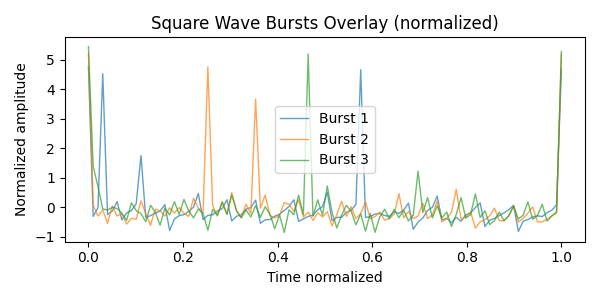

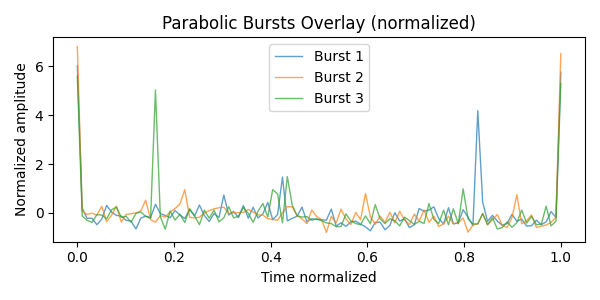

C:\Users\manur\AppData\Local\Temp\ipykernel_13372\2028775586.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


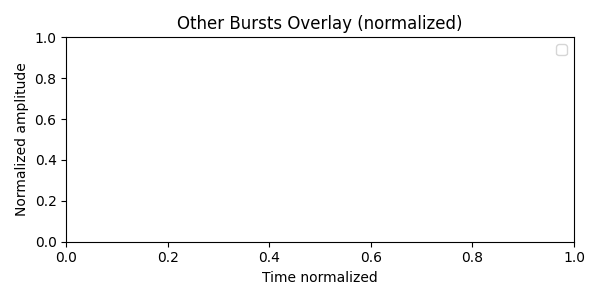

In [9]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# ==== Cargar datos ====
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)

signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])
dt = 1.0 / abf.dataRate
time = np.arange(len(signal)) * dt

# ==== Detección de spikes ====
threshold = -35  # mV
spike_indices, _ = find_peaks(signal, height=threshold)
spike_times = time[spike_indices]

# ==== Detección de bursts ====
isi = np.diff(spike_times)
burst_threshold = 0.3  # s

bursts = []
current_burst = [spike_times[0]]
for i in range(1, len(isi)):
    if isi[i-1] < burst_threshold:
        current_burst.append(spike_times[i])
    else:
        if len(current_burst) > 1:
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

# ==== Clasificación de bursts ====
square_wave_bursts = []
parabolic_bursts = []
other_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min = np.min(signal[burst_mask])

    prev_mean = np.mean(signal[(time > bursts[i-1][1]) & (time < burst_start)]) if i > 0 else np.nan
    next_mean = np.mean(signal[(time > burst_end) & (time < bursts[i+1][0])]) if i < len(bursts)-1 else np.nan
    inter_mean = np.nanmean([prev_mean, next_mean])

    if burst_min > inter_mean:
        square_wave_bursts.append((burst_start, burst_end))
    elif burst_min < inter_mean:
        parabolic_bursts.append((burst_start, burst_end))
    else:
        other_bursts.append((burst_start, burst_end))

# ==== Funciones de normalización ====
def normalize_y(signal_segment):
    return (signal_segment - np.mean(signal_segment)) / np.std(signal_segment)

def rescale_x(time_segment, signal_segment, n_points=100):
    f = interp1d(np.linspace(0, 1, len(signal_segment)), signal_segment)
    return f(np.linspace(0, 1, n_points))

# ==== Función para overlay de bursts ====
def overlay_bursts(burst_list, tipo, n=3):
    n_to_plot = min(n, len(burst_list))
    plt.figure(figsize=(6, 3))
    
    for i in range(n_to_plot):
        start, end = burst_list[i]
        mask = (time >= start) & (time <= end)
        t_burst = time[mask]
        s_burst = signal[mask]

        # Normalizar
        s_rescaled = rescale_x(t_burst, s_burst, n_points=100)
        s_normalized = normalize_y(s_rescaled)

        plt.plot(np.linspace(0, 1, 100), s_normalized, lw=1, alpha=0.7, label=f'Burst {i+1}')

    plt.title(f"{tipo} Bursts Overlay (normalized)")
    plt.xlabel("Time normalized")
    plt.ylabel("Normalized amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==== Graficar overlay de 3 bursts de cada tipo ====
overlay_bursts(square_wave_bursts, "Square Wave", n=3)
overlay_bursts(parabolic_bursts, "Parabolic", n=3)
overlay_bursts(other_bursts, "Other", n=3)


In [10]:
import pyabf
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# ==== Funciones de preprocesamiento ====
def normalize_y(signal_segment):
    """Normaliza amplitud (z-score)"""
    return (signal_segment - np.mean(signal_segment)) / np.std(signal_segment)

def rescale_x(time_segment, signal_segment, n_points=100):
    """Reescala duración"""
    f = interp1d(np.linspace(0, 1, len(signal_segment)), signal_segment)
    return f(np.linspace(0, 1, n_points))

def detect_spikes(signal, threshold=-35):
    """Detecta spikes en la señal"""
    spike_indices, _ = find_peaks(signal, height=threshold)
    return spike_indices

def detect_bursts(spike_times, burst_threshold=0.3):
    """Detecta bursts a partir de spikes usando ISI"""
    isi = np.diff(spike_times)
    bursts = []
    current_burst = [spike_times[0]]
    for i in range(1, len(isi)):
        if isi[i-1] < burst_threshold:
            current_burst.append(spike_times[i])
        else:
            if len(current_burst) > 1:
                bursts.append((current_burst[0], current_burst[-1]))
            current_burst = [spike_times[i]]
    if len(current_burst) > 1:
        bursts.append((current_burst[0], current_burst[-1]))
    return bursts

def classify_bursts(bursts, signal, time):
    """Clasifica bursts en Square Wave, Parabolic y Other"""
    square_wave_bursts = []
    parabolic_bursts = []
    other_bursts = []

    for i, (burst_start, burst_end) in enumerate(bursts):
        burst_mask = (time >= burst_start) & (time <= burst_end)
        burst_min = np.min(signal[burst_mask])

        prev_mean = np.mean(signal[(time > bursts[i-1][1]) & (time < burst_start)]) if i > 0 else np.nan
        next_mean = np.mean(signal[(time > burst_end) & (time < bursts[i+1][0])]) if i < len(bursts)-1 else np.nan
        inter_mean = np.nanmean([prev_mean, next_mean])

        if burst_min > inter_mean:
            square_wave_bursts.append((burst_start, burst_end))
        elif burst_min < inter_mean:
            parabolic_bursts.append((burst_start, burst_end))
        else:
            other_bursts.append((burst_start, burst_end))

    return square_wave_bursts, parabolic_bursts, other_bursts

def extract_normalized_bursts(burst_list, signal, time, n_points=100):
    """Extrae bursts y normaliza en X e Y para shapelet learning"""
    normalized_bursts = []
    for start, end in burst_list:
        mask = (time >= start) & (time <= end)
        t_burst = time[mask]
        s_burst = signal[mask]

        s_rescaled = rescale_x(t_burst, s_burst, n_points=n_points)
        s_normalized = normalize_y(s_rescaled)

        normalized_bursts.append(s_normalized)
    return normalized_bursts


# ==== Cargar señal ====
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)

signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])
dt = 1.0 / abf.dataRate
time = np.arange(len(signal)) * dt

# ==== Detectar spikes y bursts ====
spike_indices = detect_spikes(signal)
spike_times = time[spike_indices]

bursts = detect_bursts(spike_times)

# ==== Clasificar bursts ====
square_wave_bursts, parabolic_bursts, other_bursts = classify_bursts(bursts, signal, time)

# ==== Extraer bursts normalizados para shapelet learning ====
n_points = 100
square_bursts_normalized = extract_normalized_bursts(square_wave_bursts, signal, time, n_points)
parabolic_bursts_normalized = extract_normalized_bursts(parabolic_bursts, signal, time, n_points)
other_bursts_normalized = extract_normalized_bursts(other_bursts, signal, time, n_points)

# Ahora `*_bursts_normalized` son listas de arrays listos para usar como shapelets
# Por ejemplo: podrías concatenarlos o usarlos para entrenamiento
all_normalized_bursts = square_bursts_normalized + parabolic_bursts_normalized + other_bursts_normalized
labels = ([0]*len(square_bursts_normalized) +
          [1]*len(parabolic_bursts_normalized) +
          [2]*len(other_bursts_normalized))

In [12]:
# ==== Visualización 2D ====
viridis = cm.get_cmap('viridis', 4)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax4 = fig.add_subplot(gs[:, 4:])

# Shapelets
fig_ax1.plot(shp_clf.shapelets_[0].flatten())
fig_ax1.set_title('Shapelet $\\mathbf{s}_1$')
fig_ax2.plot(shp_clf.shapelets_[1].flatten())
fig_ax2.set_title('Shapelet $\\mathbf{s}_2$')

# Scatter plot 2D de las distancias
for i, label in enumerate(np.unique(y)):
    fig_ax4.scatter(distances[y == label][:, 0],
                    distances[y == label][:, 1],
                    c=[viridis(i / max(1, len(np.unique(y)) - 1))] * np.sum(y == label),
                    edgecolors='k',
                    label=f'Class {label}')

# ==== Decision boundaries ====
xmin = np.min(distances[:, 0]) - 0.1
xmax = np.max(distances[:, 0]) + 0.1
ymin = np.min(distances[:, 1]) - 0.1
ymax = np.max(distances[:, 1]) + 0.1
xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) / 200),
                     np.arange(ymin, ymax, (ymax - ymin) / 200))

# Pesos de la capa final
W, b = shp_clf.model_.get_layer("classification").get_weights()
n_classes = len(np.unique(y))

Z = []
for x_val, y_val in np.c_[xx.ravel(), yy.ravel()]:
    if n_classes == 2:
        # Caso binario → salida sigmoide (1 sola neurona)
        logit = b[0] + W[0, 0] * x_val + W[1, 0] * y_val
        pred = 1 if logit >= 0 else 0
    else:
        # Caso multiclase → softmax (n_classes neuronas)
        scores = [b[i] + W[0, i] * x_val + W[1, i] * y_val
                  for i in range(n_classes)]
        pred = np.argmax(scores)
    Z.append(pred)

Z = np.array(Z).reshape(xx.shape)
fig_ax4.contourf(xx, yy, Z / max(1, n_classes - 1), cmap=viridis, alpha=0.25)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\\mathbf{x}, \\mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\\mathbf{x}, \\mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed bursts')
plt.show()

NameError: name 'cm' is not defined

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets

# ==== Preparar datos ====
# all_normalized_bursts y labels provienen del código anterior
# Convertimos a numpy array 3D (n_samples, ts_size, 1)
X = np.array(all_normalized_bursts)
X = X[:, :, np.newaxis]  # Añadimos dimensión de canal
y = np.array(labels)

# Normalizamos cada burst entre 0 y 1 (opcional, refuerzo)
X = TimeSeriesScalerMinMax().fit_transform(X)

# ==== Configuración del modelo de shapelets ====
n_shapelets_per_size = {X.shape[1]: 2}  # 2 shapelets del tamaño de cada burst
shp_clf = LearningShapelets(
    n_shapelets_per_size=n_shapelets_per_size,
    weight_regularizer=0.0001,
    optimizer=Adam(0.01),
    max_iter=300,
    verbose=0,
    scale=False,
    random_state=42
)

# Entrenamos
shp_clf.fit(X, y)

# ==== Distancias transformadas a 2D ====
distances = shp_clf.transform(X).reshape((-1, 2))

# ==== Visualización 2D ====
viridis = cm.get_cmap('viridis', 4)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax4 = fig.add_subplot(gs[:, 4:])

# Shapelets
fig_ax1.plot(shp_clf.shapelets_[0].flatten())
fig_ax1.set_title('Shapelet $\\mathbf{s}_1$')
fig_ax2.plot(shp_clf.shapelets_[1].flatten())
fig_ax2.set_title('Shapelet $\\mathbf{s}_2$')

# Scatter plot 2D de las distancias
for i, label in enumerate(np.unique(y)):
    fig_ax4.scatter(distances[y == label][:, 0],
                    distances[y == label][:, 1],
                    c=[viridis(i / max(1, len(np.unique(y)) - 1))] * np.sum(y == label),
                    edgecolors='k',
                    label=f'Class {label}')

# ==== Decision boundaries ====
xmin = np.min(distances[:, 0]) - 0.1
xmax = np.max(distances[:, 0]) + 0.1
ymin = np.min(distances[:, 1]) - 0.1
ymax = np.max(distances[:, 1]) + 0.1
xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) / 200),
                     np.arange(ymin, ymax, (ymax - ymin) / 200))

# Pesos de la capa final
W, b = shp_clf.model_.get_layer("classification").get_weights()
n_classes = len(np.unique(y))

Z = []
for x_val, y_val in np.c_[xx.ravel(), yy.ravel()]:
    if n_classes == 2:
        # Caso binario → salida sigmoide
        logit = b[0] + W[0, 0] * x_val + W[1, 0] * y_val
        pred = 1 if logit >= 0 else 0
    else:
        # Caso multiclase → softmax
        scores = [b[i] + W[0, i] * x_val + W[1, i] * y_val
                  for i in range(n_classes)]
        pred = np.argmax(scores)
    Z.append(pred)

Z = np.array(Z).reshape(xx.shape)
fig_ax4.contourf(xx, yy, Z / max(1, n_classes - 1), cmap=viridis, alpha=0.25)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\\mathbf{x}, \\mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\\mathbf{x}, \\mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed bursts')
plt.show()

NameError: name 'Adam' is not defined